In [2]:
# %% [code]
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from deap import base, creator, tools, algorithms

# Constants for the rocket
g0 = 9.81  # gravitational acceleration in m/s²
Isp = np.array([300, 350, 380])  # specific impulse for each stage (s)

# Input Parameters for the analysis
vf = 1  # target/exhaust velocity (m/s) used in the equation formulation
beta = np.array([0.5, 0.3, 0.2])       # stage weight fractions
epsilon = np.array([0.08, 0.10, 0.15])   # structural mass fractions
alpha = np.array([1.1, 1.2, 1.3])        # stage efficiency factors

# List of solvers to try
solvers = ['newton', 'bisection', 'secant', 'scipy', 'genetic']

# Make sure the DEAP creator components are defined only once
if not hasattr(creator, "FitnessMin"):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)


def Nstage(vf, beta, epsilon, alpha, solver='newton', tol=1e-9, max_iter=100):
    """
    Finds the optimal staging parameter `p` such that the function
      f(p) = vf + sum[ beta_i * ln( epsilon_i + alpha_i * (1 - epsilon_i) * p ) ]
    is zero (within tolerance). This parameter is then used to calculate
    the delta-V for each stage.

    Parameters:
      vf       : float
                 A velocity term used in the formulation (m/s).
      beta     : np.array
                 Array of stage weight fractions.
      epsilon  : np.array
                 Array of structural mass fractions for each stage.
      alpha    : np.array
                 Array of stage efficiency factors.
      solver   : str, optional
                 The solver method to use. Options include:
                   - 'newton'   : Newton-Raphson method.
                   - 'bisection': Bisection method.
                   - 'secant'   : Secant method.
                   - 'scipy'    : SciPy’s brentq method.
                   - 'genetic'  : Genetic algorithm using DEAP.
      tol      : float, optional
                 Tolerance for convergence.
      max_iter : int, optional
                 Maximum number of iterations allowed.

    Returns:
      p : float
          The optimal staging parameter.
          
    Raises:
      ValueError if the solver does not converge or if an invalid solver is chosen.
    """

    def f(p):
        # Restrict p to a valid range to avoid log(0) issues.
        p = np.clip(p, 1e-6, 1)
        # Use np.maximum to avoid taking log of zero or negative numbers.
        return vf + np.sum(beta * np.log(np.maximum(epsilon + alpha * (1 - epsilon) * p, 1e-9)))

    def df(p):
        # Derivative of f(p) with respect to p.
        p = np.clip(p, 1e-6, 1)
        return np.sum(alpha * beta / np.maximum(epsilon + alpha * (1 - epsilon) * p, 1e-9))

    if solver == 'newton':
        p = 0.1  # initial guess
        for _ in range(max_iter):
            f_p = f(p)
            df_p = df(p)
            if abs(f_p) < tol:
                return p
            if abs(df_p) < 1e-12:
                raise ValueError("Newton's method encountered a near-zero derivative.")
            p -= f_p / df_p
        raise ValueError("Newton's method did not converge within the maximum iterations.")

    elif solver == 'bisection':
        a, b = 0, 1
        # Check if the initial bracket is valid; if not, attempt to expand it.
        if f(a) * f(b) > 0:
            for _ in range(10):
                a -= 0.1
                b += 0.1
                if f(a) * f(b) < 0:
                    break
            else:
                raise ValueError("Bisection method: could not find a valid bracket.")
        for _ in range(max_iter):
            p = (a + b) / 2
            f_p = f(p)
            if abs(f_p) < tol:
                return p
            if f(a) * f_p < 0:
                b = p
            else:
                a = p
        raise ValueError("Bisection method did not converge.")

    elif solver == 'secant':
        p0, p1 = 0.1, 0.9  # initial guesses
        for _ in range(max_iter):
            f_p0 = f(p0)
            f_p1 = f(p1)
            if abs(f_p1) < tol:
                return p1
            if abs(f_p1 - f_p0) < 1e-12:
                raise ValueError("Secant method encountered nearly identical function values.")
            p_new = p1 - f_p1 * (p1 - p0) / (f_p1 - f_p0)
            p0, p1 = p1, p_new
        raise ValueError("Secant method did not converge.")

    elif solver == 'scipy':
        sol = root_scalar(f, bracket=[0, 1], method='brentq', xtol=tol)
        if sol.converged:
            return sol.root
        raise ValueError("SciPy brentq method did not converge.")

    elif solver == 'genetic':
        # Setup DEAP toolbox for a genetic algorithm search
        toolbox = base.Toolbox()
        toolbox.register("attr_float", np.random.uniform, 0, 1)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=1)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("evaluate", lambda ind: (abs(f(ind[0])),))
        toolbox.register("mate", tools.cxBlend, alpha=0.5)
        toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
        toolbox.register("select", tools.selTournament, tournsize=3)

        pop = toolbox.population(n=100)
        # Run the genetic algorithm
        algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=50, verbose=False)
        best_individual = tools.selBest(pop, k=1)[0]
        return best_individual[0]

    else:
        raise ValueError("Invalid solver selection: choose one of 'newton', 'bisection', 'secant', 'scipy', or 'genetic'.")


In [3]:
# %% [code]
# Dictionary to store results from each solver
results = {}

for solver in solvers:
    start_time = time.time()
    try:
        p_opt = Nstage(vf, beta, epsilon, alpha, solver=solver)
        elapsed_time = time.time() - start_time
        # If p_opt is valid, compute the delta-V for each stage.
        if p_opt is not None:
            # Delta-V calculation for each stage using the rocket equation:
            # ΔV = Isp * g0 * ln[(ε + α(1-ε)p) / ε]
            ratio = (epsilon + alpha * (1 - epsilon) * p_opt) / epsilon
            deltaV = Isp * g0 * np.log(np.maximum(ratio, 1e-9))
        else:
            deltaV = None
        results[solver] = {'p_opt': p_opt, 'deltaV': deltaV, 'time': elapsed_time}
    except ValueError as e:
        results[solver] = {'p_opt': None, 'deltaV': None, 'time': None}
        print(f"Solver {solver} failed: {e}")

# Print the results in a clear format
for solver in solvers:
    res = results[solver]
    print(f"Solver: {solver}")
    print(f"  Optimal p: {res['p_opt']}")
    print(f"  Delta-V (per stage): {res['deltaV']}")
    print(f"  Computation time: {res['time']:.4f} sec\n" if res['time'] is not None else "  Computation time: N/A\n")


Solver: newton
  Optimal p: 0.25645340412578876
  Delta-V (per stage): [4254.21881172 4556.23583694 3955.12862992]
  Computation time: 0.0010 sec

Solver: bisection
  Optimal p: 0.2564534042030573
  Delta-V (per stage): [4254.21881239 4556.2358377  3955.12863065]
  Computation time: 0.0021 sec

Solver: secant
  Optimal p: 0.2564534042495533
  Delta-V (per stage): [4254.2188128  4556.23583816 3955.12863109]
  Computation time: 0.0000 sec

Solver: scipy
  Optimal p: 0.2564534042239886
  Delta-V (per stage): [4254.21881258 4556.2358379  3955.12863085]
  Computation time: 0.0010 sec

Solver: genetic
  Optimal p: 0.25645340422389373
  Delta-V (per stage): [4254.21881258 4556.2358379  3955.12863085]
  Computation time: 0.1429 sec



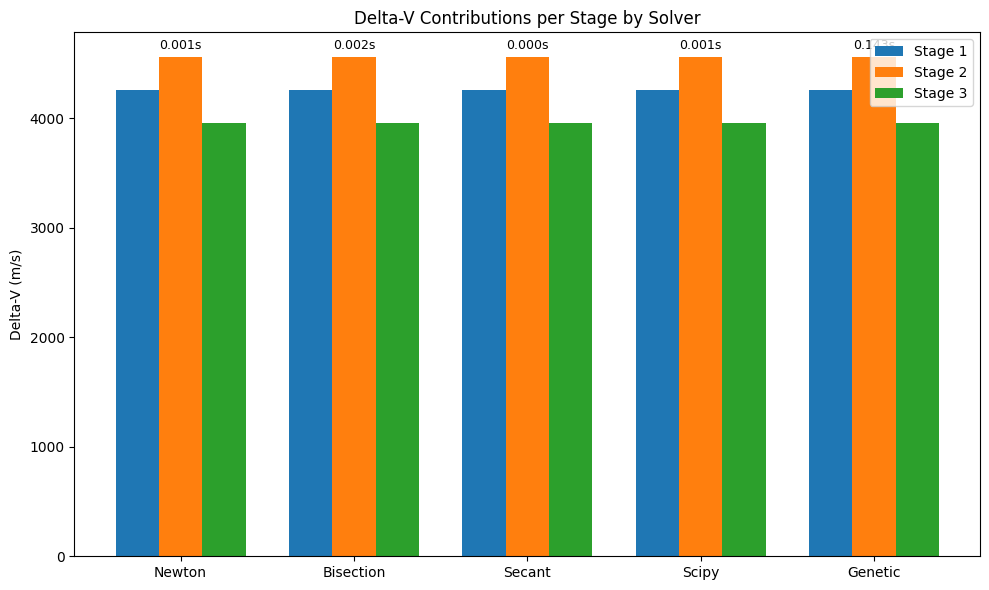

In [4]:
# %% [code]
# Prepare data for plotting
solver_names = []
stage1_dv = []
stage2_dv = []
stage3_dv = []
comp_times = []

for solver in solvers:
    solver_names.append(solver.capitalize())
    res = results[solver]
    if res['deltaV'] is not None:
        # Each deltaV is an array for the three stages.
        stage1_dv.append(res['deltaV'][0])
        stage2_dv.append(res['deltaV'][1])
        stage3_dv.append(res['deltaV'][2])
        comp_times.append(res['time'])
    else:
        stage1_dv.append(0)
        stage2_dv.append(0)
        stage3_dv.append(0)
        comp_times.append(0)

# Set up the bar width and positions
x = np.arange(len(solver_names))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, stage1_dv, width, label='Stage 1')
rects2 = ax.bar(x, stage2_dv, width, label='Stage 2')
rects3 = ax.bar(x + width, stage3_dv, width, label='Stage 3')

ax.set_ylabel('Delta-V (m/s)')
ax.set_title('Delta-V Contributions per Stage by Solver')
ax.set_xticks(x)
ax.set_xticklabels(solver_names)
ax.legend()

# Optionally annotate computation times above each group
for i, t in enumerate(comp_times):
    ax.text(x[i], max(stage1_dv[i], stage2_dv[i], stage3_dv[i]) + 50,
            f"{t:.3f}s", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
